In [40]:
import numpy as np
import pandas as pd
import re 
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import one_hot
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pickle


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Viniciu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing dataset

In [2]:
df= pd.read_csv("news.csv")
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [4]:
df['label'].value_counts(normalize=True)

REAL    0.500552
FAKE    0.499448
Name: label, dtype: float64

C:\Users\Viniciu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

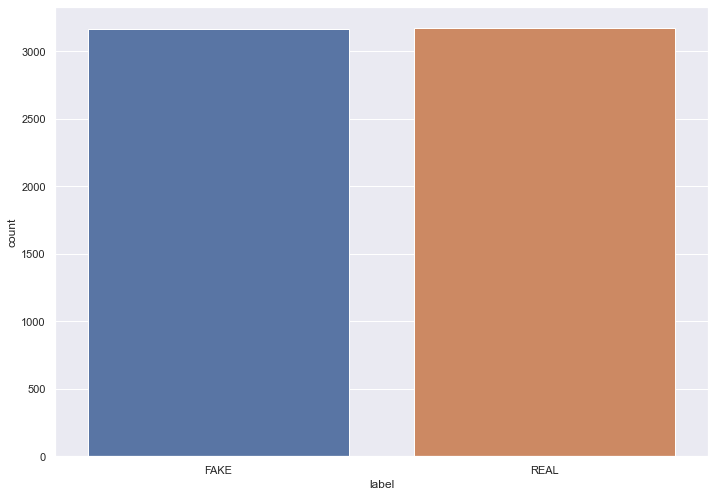

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(df['label'])

# Pre-Processing 

In [6]:
df["label"] = df["label"].map({"REAL": 0, "FAKE": 1}) #Replacing the real and fake for numbers in order to facilitate the processing with the data

print(df.shape)
df.head(5)

(6335, 4)


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


Now, we're going to create a function to plot bar plots to facilitate our next visualizations. 

In [7]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # fuction from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

In [8]:
# Set variables to show fake texts
mask_on = df['label'] == 1
df_text_masked = df[mask_on]['text']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
Fake_cvec = cv1.fit_transform(df_text_masked)

# Convert onion_cvec into a DataFrame
Fake_cvec_df = pd.DataFrame(Fake_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of Onion Titles cvec
print(Fake_cvec_df.shape)

(3164, 53064)


C:\Users\Viniciu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


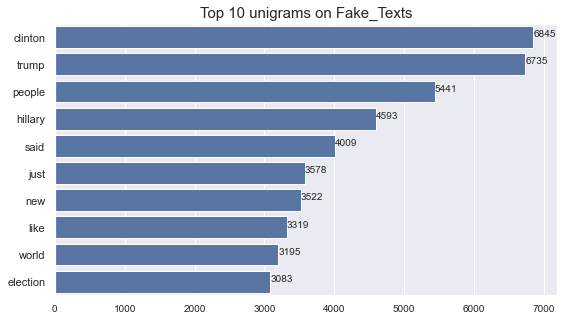

In [9]:
Fake_wc = Fake_cvec_df.sum(axis = 0)
Fake_top10 = Fake_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(Fake_top10.values,Fake_top10.index, 'Top 10 unigrams on Fake_Texts','b')

In [10]:
# Set variables to show real texts
mask = df['label'] == 0
df_real_masked = df[mask]['text']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
Real_cvec = cv1.fit_transform(df_real_masked)

# Convert onion_cvec into a DataFrame
Real_cvec_df = pd.DataFrame(Real_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of Onion Titles cvec
print(Real_cvec_df.shape)

(3171, 43364)


C:\Users\Viniciu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


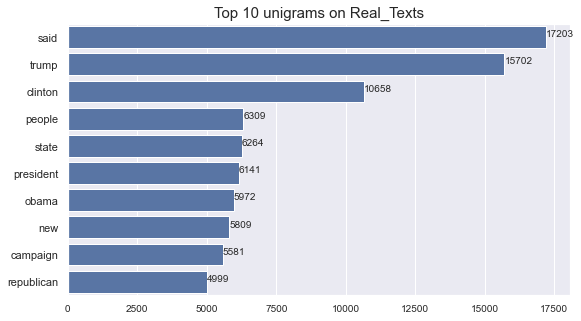

In [11]:
Real_wc = Real_cvec_df.sum(axis = 0)
Real_top10 = Real_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(Real_top10.values,Real_top10.index, 'Top 10 unigrams on Real_Texts','b')


In [12]:
# Create list of unique words in top five
Fake_10_set = set(Fake_top10.index)
Real_10_set = set(Real_top10.index)

# Return common words
common_unigrams = Fake_10_set.intersection(Real_10_set)
common_unigrams

{'clinton', 'new', 'people', 'said', 'trump'}

In [13]:
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams) 
for i in common_unigrams:
    custom.append(i)
print(custom)

['several', 'he', 'sometimes', 'behind', 'much', 'she', 'before', 'have', 'other', 'everywhere', 'often', 'un', 'could', 'his', 'throughout', 'done', 'find', 'because', 'within', 'becomes', 'hereby', 'next', 'anyone', 'thus', 'wherever', 'whereby', 'nor', 'yourself', 'become', 'first', 'therefore', 'via', 'however', 'themselves', 'therein', 'hundred', 'eleven', 'also', 'what', 'thereupon', 'again', 'anything', 'each', 'only', 'about', 'two', 'others', 'if', 'were', 'de', 'some', 'made', 'down', 'ever', 'another', 'that', 'may', 'show', 'such', 'few', 'moreover', 'herself', 'put', 'per', 'nothing', 'who', 'keep', 'someone', 'cant', 'neither', 'onto', 'namely', 'side', 'found', 'get', 'go', 'how', 'mine', 'call', 'at', 're', 'himself', 'every', 'whether', 'besides', 'without', 'perhaps', 'serious', 'same', 'seem', 'those', 'never', 'name', 'here', 'latterly', 'from', 'top', 'nobody', 'myself', 'twenty', 'nevertheless', 'upon', 'can', 'the', 'along', 'six', 'whole', 'seeming', 'must', 'he

# Testing methods

In [14]:
X = df['text']
y = df['label']
#X is our explanatory variable and y our goal variabel

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Spliting the full datasets into train and test

# TF-IDF - Passive_aggressive classifier

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Initializing the vectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words=custom)

#fitting the vectorizer in our train and test datasets
tfidf_train=tfidf_vectorizer.fit_transform(X_train) 
tfidf_test=tfidf_vectorizer.transform(X_test)

In [17]:
    from sklearn.linear_model import PassiveAggressiveClassifier
    from sklearn.metrics import accuracy_score, confusion_matrix

#Initialize a PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

#Predict on the test set and calculate accuracy
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

#Making a confusion matrix
cnf_matriz = confusion_matrix(y_test,y_pred)
print(cnf_matriz)

Accuracy: 93.37%
[[595  44]
 [ 40 588]]


In [18]:
type(y_pred)

numpy.ndarray

In [19]:
type(y_test)

pandas.core.series.Series

# TF-IFD - LogisticRegression

In [20]:
#Initializing the vectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words=custom)

#fitting the vectorizer in our train and test datasets
tfidf_train=tfidf_vectorizer.fit_transform(X_train) 
tfidf_test=tfidf_vectorizer.transform(X_test)

In [21]:
#Initialize a LogisticRegression
clf = LogisticRegression(solver='liblinear')
clf.fit(tfidf_train, y_train)

#Predict on the test set and calculate accuracy
y_pred=clf.predict(tfidf_test)
score = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 91.0%


In [22]:
#making a confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[569  70]
 [ 44 584]]


#  CountVectorizer - LogisticRegression

In [23]:
cvec = CountVectorizer(stop_words = custom)

cvec_train=cvec.fit_transform(X_train) 
cvec_test=cvec.transform(X_test)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#Initialize a PassiveAggressiveClassifier
clf = LogisticRegression(solver='liblinear')
clf.fit(cvec_train, y_train)

#Predict on the test set and calculate accuracy
ypred_=clf.predict(cvec_test)
score = accuracy_score(y_test,ypred_)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 91.87%


In [25]:
print(type(y_test))
print(type(ypred_))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [26]:
#making a confusion matrix
df_confusion = pd.crosstab(y_test, ypred_)
print(df_confusion)

col_0    0    1
label          
0      583   56
1       47  581


# Countvectorizer - Passive-aggressive classifier


In [27]:
cvec = CountVectorizer(stop_words = custom)

cvec_train=cvec.fit_transform(X_train) 
cvec_test=cvec.transform(X_test)

In [28]:
#Initialize a PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(cvec_train,y_train)

#Predict on the test set and calculate accuracy
y_pred=pac.predict(cvec_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 89.74%


In [29]:
#Making a confusion matrix
confusion_matrix=pd.crosstab(y_test, y_pred)
print(confusion_matrix)

col_0    0    1
label          
0      581   58
1       72  556


# TF-IDF - Naive_Bayes

In [30]:
#Initializing the vectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words=custom)

#fitting the vectorizer in our train and test datasets
tfidf_train=tfidf_vectorizer.fit_transform(X_train) 
tfidf_test=tfidf_vectorizer.transform(X_test)

In [31]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(tfidf_train, y_train)
predictions = naive_bayes.predict(tfidf_test)
score=accuracy_score(y_test,predictions)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 84.77%


In [32]:
#Making a confusion matrix
confusion_matrix=pd.crosstab(y_test, predictions)
print(confusion_matrix)

col_0    0    1
label          
0      627   12
1      181  447


# CountVectorizer - Naive_Bayes 

In [33]:
cvec = CountVectorizer(stop_words = custom)

cvec_train=cvec.fit_transform(X_train) 
cvec_test=cvec.transform(X_test)

In [34]:
naive_bayes = MultinomialNB()
naive_bayes.fit(cvec_train, y_train)
predictions = naive_bayes.predict(cvec_test)
score=accuracy_score(y_test,predictions)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 90.13%


In [35]:
#Making a confusion matrix
confusion_matrix=pd.crosstab(y_test, predictions)
print(confusion_matrix)

col_0    0    1
label          
0      595   44
1       81  547


# The chosen Model

Text(0.5, 527.9871999999999, 'Predicted label')

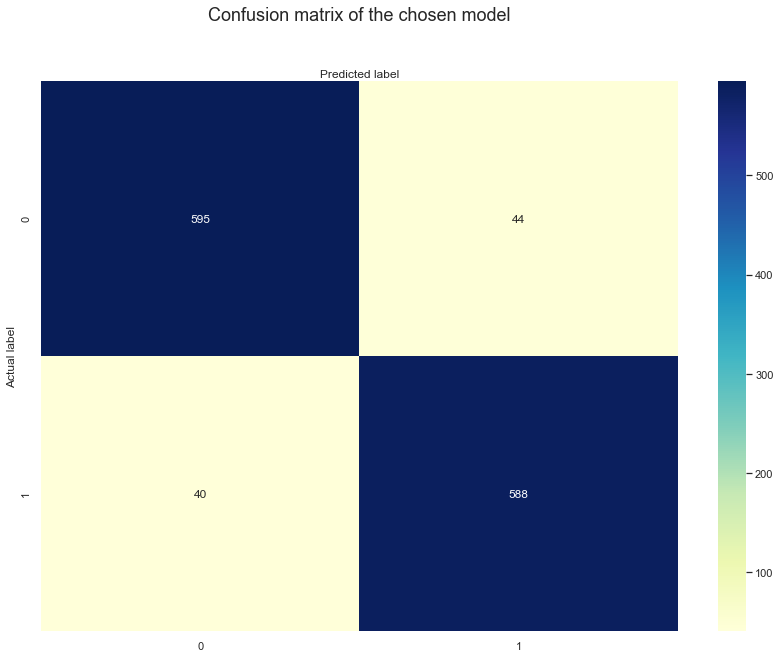

In [36]:
# Code source https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

# name  of classes
class_names=['0','1'] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matriz), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix of the chosen model', y=1.1, fontsize = "18")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Create a function to classify

In [46]:
def classify(text):
    classifyer_name = 'pac.pkl'
    pac = pickle.load(open(classifyer_name, 'rb'))
    vectorizer_name = 'tfidf_vectorizer.pkl'
    vectorizer = pickle.load(open(vectorizer_name, 'rb'))
    predictions = []
    pred = pac.predict(vectorizer.transform([text]))
    for i in pred:
        predictions.append(i)
    print(predictions)

In [47]:
new_doc=["Photos show the U.S. service members killed in a 2021 suicide bombing in Kabul.",
         'In Afghanistan, “over 100 billion dollars spent on military contracts.”', 
         'women are "disproportionately" impacted by votes of male deputades',
         'The Trump administration worked to free 5,000 Taliban prisoners.']


for doc in new_doc:
    classify(doc)

[1]
[1]
[1]
[0]


In [44]:
statements = df2["statement"]

In [45]:
for statement in statements:
    classify(statement)

1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
0
1
0
1
1
1
1
1
0
1
1
1
0
1
1
1
1
0
1
1
1
1
0
1
0
1
1
1
0
1
1
1
1
0
1
0
1
0
0
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
0
0
1
0
1
1
0
1
1
1
1
0
1
1
0
1
0
0
1
1
0
0
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
0
0
0
1
1
0
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
0
1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
0
0
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
0
1
0
0
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
0
0
1
1
1
0
1
0
0
1
0
1
0
1
1
1
1
1
1
1
0
1
0
0
1
0
1
0
1
1
1
1
1
0
1
1
1
0
0
1
1
1
1
1
0
1
0
1
1
1
0
1
1
1
1
1
1
1
0
1
1
0
1
1
0
1
1
1
0
1
0
1
1
0
1
1
0
0
0
0
1
0
1
0
1
1
1
0
1
1
1
0
0
1
1
0
0
1
1
1
0
1
1
1
1
0
1
1
1
1
0
1
1
1
1
0
1
1
1
0
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
0
1
1
0
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
0
1
1
1
0
0
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1


In [ ]:
classify(doc_2)

In [ ]:
doc_3 = 'The Trump administration worked to free 5,000 Taliban prisoners.'

classify(doc_3)

## Abaixo tudo é rascunho

In [ ]:
df2.shape

In [43]:
df2= pd.read_csv("new_ds.csv")
df2.head(25)

,Unnamed: 0,author,statement,source,date,target,BinaryNumTarget
0,0,Andy Nguyen,"""Ivermectin sterilizes the majority (85%) of t...",Facebook posts,"September 9, 2021",false,1
1,1,Gabrielle Settles,Says Nancy Pelosi on Aug. 31 blocked members o...,Facebook posts,"September 9, 2021",barely-true,1
2,2,Jon Greenberg,“The frequency of hurricanes making landfall i...,Bjorn Lomborg,"September 9, 2021",half-true,0
3,3,Tom Kertscher,“President Putin bans mandatory vaccinations i...,Instagram posts,"September 9, 2021",false,1
4,4,Amy Sherman,The Texas abortion law “provides at least six ...,Greg Abbott,"September 9, 2021",false,1
5,5,Ciara O'Rourke,"“Germany halts all Covid-19 vaccines, says the...",Bloggers,"September 9, 2021",false,1
6,6,Ciara O'Rourke,Photo shows a Chinese restaurant sign that say...,Instagram posts,"September 9, 2021",pants-fire,1
7,7,Ciara O'Rourke,“Military arrests Hunter Biden!”,Bloggers,"September 8, 2021",pants-fire,1
8,8,Tom Kertscher,Says a demonstration with an air quality monit...,Facebook posts,"September 8, 2021",false,1
9,9,Louis Jacobson,"Texas “ranks 50th in baby wellness checks, ran...",Occupy Democrats,"September 7, 2021",half-true,0


In [ ]:
df2.describe()

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(df2['BinaryNumTarget'])